## Семинар 11
# Тема:  Работа с выбросами

Выбросы – это точки данных в признаке, которые отклоняются от нормы значений этого признака.

Нет однозначного способа понять, что перед нами выброс. Разные способы обнаружения выбросов возвращают разные точки в качестве выбросов, и эти точки пересекаются лишь частично.


**Способы обнаружения выбросов:**

1. Поиск по порогу. 

Этот способ представляет собой погружение в предметную область и понимание того, какие значения признаки могут принимать, а какие - не могут.

2. Обнаружение и обработка выбросов, используя метод **IQR** (interquartile range, межквартильное расстояние).

Строим `boxplot` и все значения вне "усов" считаем выбросами. Левая линия ящика обозначает первый квартиль (25-й перцентиль q25), а правая линия ящика обозначает третий квартиль (75-й перцентиль q75). Границы "усов" определяются так: 

нижняя граница - это минимальное значение признака между q25 - (1.5*iqr) и q75 + (1.5*iqr),

верхняя граница  - это максимальное значение признака между q25 - (1.5*iqr) и q75 + (1.5*iqr), 

где  iqr = q75-q25

Метод межквартильного расстояния выделяет как выбросы все значения, находящиеся за пределами "усов".
   
3.  Поиск по отклонению (z-score)
  
Поиск по отклонению основан на поиске значения, на которое отклоняется данная точка от среднего. Делается это с помощью z-score, то есть, расстояния (измеряемого в количестве стандартных отклонений) от среднего значения точек.  

4. Поиск выбросов с помощью методов машинного обучения

Например, изолирующий лес (Isolation Forest) 

**Способы борьбы с выбросами:**

- Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем).
- Заменять выбросы разными методами (использовать знания по предметной области, медианы, средние значения, np.clip и т.д.) 
- Делать/не делать дополнительную фичу. 
- Ничего не делать

Импортируем необходимые библиотеки:

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import IsolationForest
import seaborn as sns

### 1. Загрузите датасет apartament.csv и выведите первые 5 строк. 

In [44]:
df = pd.read_csv('apartment.csv')

In [45]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


### 2. Создайте копию загруженного датафрейма и выведите информацию о данных.

In [46]:
df_1 = df.copy()

In [47]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### 3. Осуществите обнаружение выбросов **по порогу** для признака `Rooms`. Для этого используйте следующие знания по предметной области: количество комнат не может быть 0 и больше 6. Выведите индексы тех наблюдений, где количество комнат не удовлетворяет этим условиям. Подсчитайте их количество.

In [48]:
outlier_indices = df_1[(df_1['Rooms'] == 0) | (df_1['Rooms'] > 6)].index.tolist()
outlier_count = len(outlier_indices)

In [49]:
outlier_indices

[2004, 2194, 2728, 3780, 5894, 6088, 6401, 7644, 7929, 9767, 9869]

In [50]:
outlier_count

11

### 4. Обработайте выбросы в пизнаке Rooms, например, так: если число комнат равно нулю, то замените его на 1, если больше 6 - на 6. Добавьте к исходному датасету признак Rooms_outlier, в котором на местах с выбросами стоят 1, а остальные - 0. 

In [51]:
df_1['Rooms_outlier'] = 0
outlier_condition = (df_1['Rooms'] == 0) | (df_1['Rooms'] > 6)
df_1.loc[outlier_condition, 'Rooms_outlier'] = 1
df_1.loc[df_1['Rooms'] == 0, 'Rooms'] = 1
df_1.loc[df_1['Rooms'] > 6, 'Rooms'] = 6

In [52]:
df_1[['Rooms', 'Rooms_outlier']].head(10)

,Rooms,Rooms_outlier
0,3.0,0
1,1.0,0
2,3.0,0
3,1.0,0
4,2.0,0
5,3.0,0
6,1.0,0
7,2.0,0
8,1.0,0
9,3.0,0


### 5. Для признака Ecology_1 осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально определите наличие выбросов. 

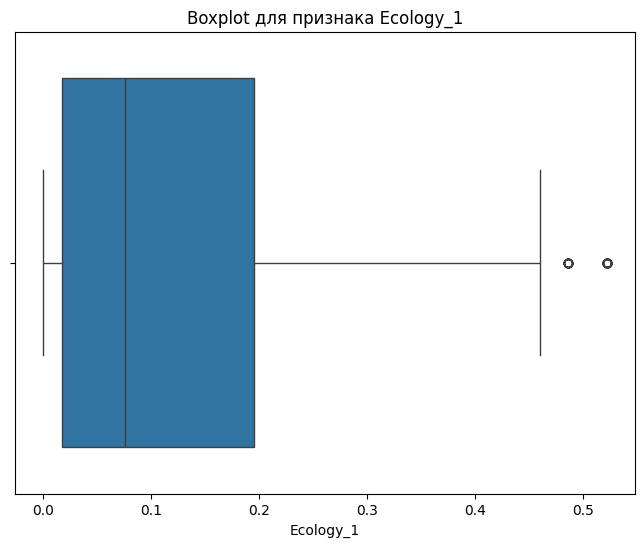

In [53]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_1['Ecology_1'])
plt.title('Boxplot для признака Ecology_1')
plt.xlabel('Ecology_1')
plt.show()

### 6. Используя функцию outliers_iqr определите индексы наблюдений с выбросами. Подсчитайте их количество.

In [54]:
def outliers_iqr(x):
    q25 = x.quantile(.25)
    q75 = x.quantile(.75)  
    iqr = q75 - q25   
    lower_bound = q25 - iqr * 1.5  
    upper_bound = q75 + iqr * 1.5 
    outliers_index = x[(x > upper_bound) | (x < lower_bound)].index
    min_border = x[(x <= upper_bound) & (x >= lower_bound)].min()
    max_border = x[(x <= upper_bound) & (x >= lower_bound)].max()
    return outliers_index, min_border, max_border

In [55]:
outliers_index, min_border, max_border = outliers_iqr(df_1['Ecology_1'])

In [56]:
outliers_index

Index([ 201,  516,  704,  719,  798,  802, 1041, 1051, 1351, 1386, 1772, 2073,
       2080, 2135, 2226, 2446, 2495, 2536, 3049, 3305, 3511, 4063, 4089, 4265,
       4373, 4519, 4561, 4719, 4985, 5082, 5200, 5244, 5311, 5401, 5420, 5439,
       5777, 5807, 5903, 6140, 6199, 6231, 6426, 7375, 7450, 7609, 7836, 8223,
       8240, 8308, 8362, 8435, 8587, 8629, 9188, 9347, 9368, 9371, 9627, 9958,
       9985],
      dtype='int64')

In [57]:
len(outliers_index)

61

In [58]:
min_border

0.0

In [59]:
max_border

0.460556389

### 7. Обработайте выбросы в пизнаке Ecology_1, например, так: замените их на np.nan и далее удалите наблюдения с пропусками в пизнаке Ecology_1.

In [60]:
outliers_index, _, _ = outliers_iqr(df_1['Ecology_1'])
df_1.loc[outliers_index, 'Ecology_1'] = np.nan
df_1_cleaned = df_1.dropna(subset=['Ecology_1']).reset_index(drop=True)

In [63]:
df_1.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [64]:
df_1_cleaned.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


### 8. Снова постройте "ящик с усами" для этого признака и убедитесь, что выбросов больше нет.

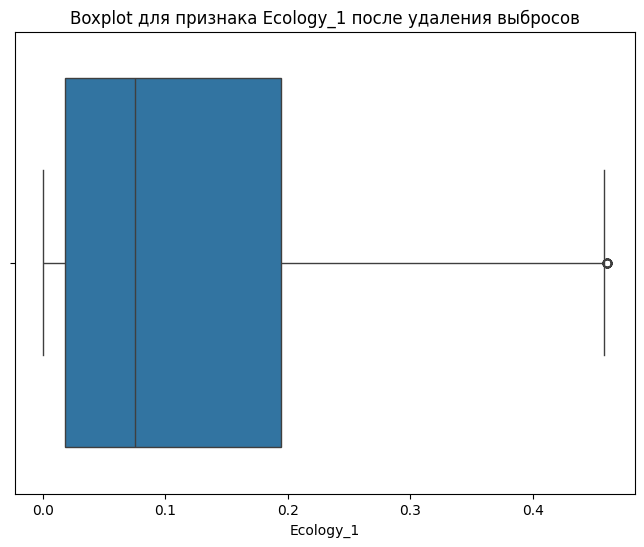

In [66]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_1_cleaned['Ecology_1'])
plt.title('Boxplot для признака Ecology_1 после удаления выбросов')
plt.xlabel('Ecology_1')
plt.show()

### 9. Для признака Square осуществите обнаружение выбросов методом **z-score**. Для этого используйте функцию outliers_z_score и определите индексы наблюдений с выбросами. Подсчитайте их количество.

In [69]:
def outliers_z_score(x, threshold=3):
    mean = np.mean(x)
    std = np.std(x)
    z_scores = [(element - mean) / std for element in x]
    print(len(z_scores))
    return np.where(np.abs(z_scores) > threshold)[0]

In [71]:
outlier_indices = outliers_z_score(df_1['Square'])

10000


In [73]:
outlier_indices

array([ 136,  286,  349,  403,  443,  511,  599,  692,  726,  730,  866,
       1086, 1172, 1352, 1449, 1459, 1606, 1614, 1692, 1729, 1776, 1851,
       1906, 1949, 1980, 2037, 2041, 2066, 2086, 2267, 2325, 2336, 2393,
       2403, 2429, 2516, 2663, 2790, 2963, 3010, 3121, 3182, 3204, 3955,
       4444, 4613, 4676, 4996, 5031, 5258, 5259, 5283, 5409, 5476, 5586,
       5631, 5764, 5844, 5992, 6030, 6099, 6209, 6343, 6450, 6500, 6549,
       6618, 6829, 6909, 7006, 7010, 7144, 7173, 7397, 7644, 7710, 7879,
       8011, 8044, 8055, 8128, 8466, 8677, 8872, 9037, 9104, 9229, 9307,
       9533, 9663, 9767, 9846, 9877])

In [74]:
len(outlier_indices)

93

### 10.  Обработайте выбросы в пизнаке Square заменив их медианным значением. Добавьте к исходному датасету признак Square_outlier, в котором на местах с выбросами стоят 1, а остальные - 0. 

In [76]:
df_1['Square_outlier'] = 0
df_1.loc[outlier_indices, 'Square_outlier'] = 1
median_value = df_1.loc[~df_1.index.isin(outlier_indices), 'Square'].median()
df_1.loc[outlier_indices, 'Square'] = median_value

In [77]:
df_1[['Square', 'Square_outlier']].head(15)

,Square,Square_outlier
0,115.027311,0
1,39.832524,0
2,78.342215,0
3,40.409907,0
4,64.285067,0
5,62.528465,0
6,33.938750,0
7,50.391814,0
8,46.887892,0
9,79.867477,0


In [78]:
median_value

52.2490400182982

# Задания для самостоятельного выполнения
Продолжите работу с рассматриваемым датасетом `apartment.csv`. 
1. Осуществите обнаружение выбросов **по порогу** для признака `KitchenSquare`. Для этого используйте следующие знания по предметной области: площадь кухни не может быть меньше 3 и больше 13 метров. Выведите индексы тех наблюдений, где это условие не выполняется. Подсчитайте их количество.
2. Обработайте выбросы в пизнаке `KitchenSquare`, например, так: площадь кухни меньше 3, то замените его на 3, если больше 13 - на медианное значение. Добавьте к исходному датасету признак `KitchenSquare_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0. 
3. Осуществите обнаружение выбросов **по порогу** для признака `Floor`. Для этого используйте следующие знания по предметной области: этаж квартиры `Floor` не должен быть больше этажности дома `HouseFloor`. Выведите индексы тех наблюдений, где это условие не выполняется. Подсчитайте их количество.
4. Обработайте выбросы в пизнаке `Floor`, например, так: замените этаж квартиры `Floor` на случайный от 0 (подвал) до числа этажей в доме `HouseFloor`. Добавьте к исходному датасету признак `Floor_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0. 
5. Для признака `Social_1` осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально убедитесь, что выбросов нет. 
6. Для признака `Social_2` осуществите обнаружение выбросов методом **IQR**. Для этого постройте "ящик с усами" для этого признака и визуально определите наличие выбросов. Используя функцию `outliers_iqr` определите индексы наблюдений с выбросами. Подсчитайте их количество.
7. Обработайте выбросы в пизнаке `Social_2`, например, так: замените их на np.nan и далее удалите наблюдения с пропусками.
8. Для признака `Social_3` осуществите обнаружение выбросов методом **z-score**. Для этого используйте функцию `outliers_z_score` и определите индексы наблюдений с выбросами. Подсчитайте их количество.
9.  Обработайте выбросы в пизнаке `Social_3` заменив их медианным значением. Добавьте к исходному датасету признак `Social_3_outlier`, в котором на местах с выбросами стоят 1, а остальные - 0.
10. Осуществите обнаружение выбросов для признака `HouseYear` используя модель IsolationForest(contamination = 0.1, random_state = 42).